## Import Library

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action="ignore")

DATA_PATH = "/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/"

## EDA

### Data overview
> *추가 Feature 설명*  
> *원래 라벨링: 여러 명의 annotator(사람)가 각 댓글에 대해 해당 속성이 있는지 여부를 0 또는 1로 표시함.*  
> *최종 값: 각 속성에 대해 모든 annotator의 평균값을 사용 → 결과적으로 0~1 사이의 연속값이 됨.*  

* train  
  id: 그냥 넘버링  
  target: 댓글 공격성 (if toxicity >= 0.5 else 0 적용전)  
  comment_text: 대상 댓글
    
  *추가 Feature-세부공격성*  
  severe_toxitiy: 극단적 공격성 정도 [0,1]  
  obscene: 성적 비하 정도 [0,1]  
  identity_attack: 정체성(성별,종교,인종 등) 공격 정도 [0,1]  
  insult: 일반적 모욕성 정도 [0,1]  
  threat: 위해,위협 정도 [0,1]  
  sexual_explicit: 성적인 묘사 정도 [0,1]
    
  *추가 Feature-identity*  
  asian: 아시아인 언급여부  
  atheist: 무신론자 언급여부  
  bisexual: 양성애자 언급여부  
  black: 흑인 언급여부  
  buddhist: 불교신자 언급여부  
  christian: 기독교인 언급여부  
  female: 여성 언급여부  
  heterosexual: 이성애자 언급여부  
  hindu: 힌두교신자 언급여부  
  homosexual_gay_or_lesbian: 게이,레즈 언급여부  
  intellectual_or_learning_disability: 지적,학습장애 언급여부  
  jewish: 유대인 언급여부  
  latino: 중남미출신 언급여부  
  male: 남성 언급여부  
  muslim: 이슬람교인 언급여부  
  other disability: 지적,신체적 장애 외 기타장애 언급여부  
  other_gender: 남성,여성,트렌스젠더 외 다른 성별 언급여부  
  other_race_or_ethnicity: 흑인,백인,라틴,아시아인,아메리카원주민 외 다른 인종 언급여부  
  other_religion: 기독교,불교,유대교,이슬람교,힌두교 외 다른 종교 언급여부  
  other_sexual_orientation: 이성애자,동성애자,양성애자,게이,레즈 외 다른 성적정체성 언급여부  
  physical_disability: 신체적 장애 언급여부  
  psychiatric_or_mental_illness: 정신적 질병 언급여부  
  transgender: 트렌스젠더 언급여부  
  white: 백인 언급여부
    
  *추가 Feature-meta data*  
  created_date: 댓글 작성날짜  
  publication_id: 댓글달린 기사의 출판물 ID  
  parent_id: 댓글이 답글인 경우 부모 댓글 ID  
  article_id: 댓글이 달린 기사의 ID  
  rating: 댓글 공개 혹은 차단 여부 ['rejected', 'approved']    
  funny: 재밌어요 반응수  
  wow: 놀라워요 반응수  
  sad: 슬퍼요 반응수  
  likes: 좋아요 반응수  
  disagree: 동의하지 않아요 반응수  
  identity_annotator_count: identity 관련 feature 라벨링 참여인 수  
  toxicity_annotator_count: toxicity 관련 feature 라벨링 참여인 수

* test  
  id: 그냥 넘버링    
  comment_text: 대상 댓글

In [25]:
df_train = pd.read_csv(DATA_PATH+"train.csv")
df_test = pd.read_csv(DATA_PATH+"test.csv")
df_sample = pd.read_csv(DATA_PATH+"sample_submission.csv")

In [ ]:
'''
all_data.csv
│
├── train.csv                     # 학습 데이터 (1.8M행)
└── test.csv                      # 채점용 데이터 (0.6M행)
     ├── test_public_expanded.csv   # test의 20% (Public LB용)
     └── test_private_expanded.csv  # test의 80% (Private LB용)

df_all = pd.read_csv(DATA_PATH+"all_data.csv")
df_identity = pd.read_csv(DATA_PATH+"identity_individual_annotations.csv")
df_toxicity = pd.read_csv(DATA_PATH+"toxicity_individual_annotations.csv")
df_test_private_expanded = pd.read_csv(DATA_PATH+"test_private_expanded.csv")
df_test_public_expanded = pd.read_csv(DATA_PATH+"test_public_expanded.csv")
'''

In [17]:
df_train['rating'].unique()

array(['rejected', 'approved'], dtype=object)

In [3]:
df_train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [4]:
pd.set_option("display.max_colwidth", None) # 텍스트 데이터 생략 없이 전체 표기.
'''
여러 컬럼은 전달 시 dataframe 2차원이라서 두겹으로 작성.
단일 컬럼은 series라서 한겹.
'''
df_train.sample(30)[['id', 'target', 'comment_text']]

,id,target,comment_text
107097,373113,0.200000,"The key to your post is the last three words ""Respect your neighbors."" It's like putting loud exhaust on your vehicle. While you may truly love the way it sounds, chances are your neighbors don't feel the same way, especially when you start it up and let it run for 20-30 minutes and then stuff your foot in it when you leave."
1390667,5818146,0.000000,"Antarctic Ice Extent is also at Record Low levels this month. Deniers like to tout the ""Record"" part of that, without bothering to check whether it is a Record Low or High. Antarctica is losing gigatonnes / cubic km of ice every year. Arctic Ice volume has declined by over 16 million cubic km, enough melted multiyear ice to cover 8 million sq km of the arctic with ice 2 meters thick.\n\nhttp://nsidc.org/data/seaice_index/images/daily_images/S_stddev_timeseries.png\n\nhttp://psc.apl.uw.edu/wordpress/wp-content/uploads/schweiger/ice_volume/BPIOMASIceVolumeAnomalyCurrentV2.1.png"
927392,5254118,0.400000,Americans would rather have free weed than free dental care.
77062,336925,0.000000,"Find out if there's a ferry in dry dock and then move the Republican majority to that ship. If that doesn't work, the National Guard can set up several of their large canvas tents. I'm sure the Alaska Native Brotherhood and Sisterhood camps will gladly donate a continental breakfast each morning, and other restaurants and businesses in the community will appreciate the extra legislative housing. See, won't that be cheaper than moving back to Anchorage and sneaking around to campaign while they're suppose to be working on the Governor's fiscal plan? Don't let them leave Juneau, Governor Walker."
342615,662696,0.166667,Hmmmm would that be the politician that calls a referendum and then looks like a Bozo and has to resign in disgrace becasue he had no idea about how the common person thinks or feels about the policies of the government?\n\nThe clowns are being outed but they don't seem to be the populists.
934090,5262042,0.000000,The examination/questioning of violence in the aboriginal community was disallowed from the outset. The inquest is probably finding it impossible to focus anywhwere else. Ergo no progress.
582138,954721,0.800000,An uncertain political environment in the United States. . . .unbelievable what kind of rabid socialist crap fear mongering great main stream media like G&M is prepared to dilute itself to.
882129,5199963,0.000000,"If Ontario could ""dump"" Wynne and the Liberals, a Party that cared about the future of Ontario might want to buy this hydro from Quebec and slowly phase out the costly Wynnemills and solar energy program."
1367373,5788585,0.478261,You and others like you are the racists. You want to rewrite history and live you life with you head stuck in sand like an ostrich.
1288560,5689211,0.000000,That's not de Tocqueville *again* . . .


In [5]:
df_train.shape

(1804874, 45)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

In [7]:
def missing_count(df: pd.DataFrame) -> pd.Series:
    """
    각 컬럼별 결측치 개수를 반환하는 함수
    df.count() 기반으로 계산
    """
    n_rows = len(df)
    return n_rows - df.count()
    # df.count()는 non-null만 세기에 isnull.sum()보다 빠름

missing = missing_count(df_train)
print(missing)

id                                           0
target                                       0
comment_text                                 3
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male         

In [8]:
# 문자형 unique 확인
df_train.describe(include="object").T

,count,unique,top,freq
comment_text,1804871,1780822,Well said.,184
created_date,1804874,1804362,2015-10-13 18:40:35.757707+00,4
rating,1804874,2,approved,1684758


In [9]:
# 수치형 
df_train.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
id,1804874.0,3738433.79,2445186.76,59848.0,796975.25,5223774.5,5769854.50,6334010.00
target,1804874.0,0.10,0.20,0.0,0.00,0.0,0.17,1.00
severe_toxicity,1804874.0,0.00,0.02,0.0,0.00,0.0,0.00,1.00
obscene,1804874.0,0.01,0.06,0.0,0.00,0.0,0.00,1.00
identity_attack,1804874.0,0.02,0.08,0.0,0.00,0.0,0.00,1.00
insult,1804874.0,0.08,0.18,0.0,0.00,0.0,0.09,1.00
threat,1804874.0,0.01,0.05,0.0,0.00,0.0,0.00,1.00
asian,405130.0,0.01,0.09,0.0,0.00,0.0,0.00,1.00
atheist,405130.0,0.00,0.05,0.0,0.00,0.0,0.00,1.00
bisexual,405130.0,0.00,0.03,0.0,0.00,0.0,0.00,1.00


In [22]:
df_test.head()

,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\nDoes this apply to President Trump too?
1,7097321,This is malfeasance by the Administrator and the Board. They are wasting our money!
2,7097322,"@Rmiller101 - Spoken like a true elitist. But look out bud. The re-awakening in Europe, Brexit and now the Trump victory are just the beginning. The unwashed masses are coming for you and your ilk…."
3,7097323,"Paul: Thank you for your kind words. I do, indeed, have strong beliefs and don't hide them. They are based on both facts and values. I think the question of ""bias"" and ""prejudice"" comes into play when we're discussing beliefs and attitudes based on values. One of our poster friends, for example, often comments that being ""intolerant"" of a bias, for example, is, in itself, a bias. This is, IMO, where the concept of ""irratonal antipathy"" is important. If I dislike neo-Nazis because of their views on race, my antipathy is based on fact (knowledge of their views) and values (my belief that condemning others because of their race/religion is WRONG). Were I to, instead, dislike all Germans, that, IMO, would represent a bias...an irrational antipathy...since not all Germans condemn others because of their race/religion. I discuss the ""bias"" question in another response to you....\n\nIt's an interesting topic and I'd enjoy discussing it w/you sometime. Give me a call. Gary Crum"
4,7097324,Sorry you missed high school. Eisenhower sent troops to Vietnam after the French withdrew in 1954 and before that America was providing 50% of the cost of that war. WWI & WWII were won by Democrat Presidents and the last win a Republican had was 1865 but the did surrender in Korea and Vietnam and fail to win in desert Storm or these two wars.


In [15]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97320 entries, 0 to 97319
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            97320 non-null  int64 
 1   comment_text  97320 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [23]:
df_test.shape

(97320, 2)

### Visualization

### count check
* 데이터 불균형 심함
* 0이 아니라 1 맞추는 것에 집중
* toxicity가 있는 문장들의 경우 주기성이 보임. 점수 마킹 후 정규화의 패턴으로 추측

In [39]:
df_train['target_bin'] = df_train['target'].map(
    lambda x : 1 if x>=0.5 else 0
) # 임의로 설정해서 toxicity와 아닌 문장의 비율을 확인

df_train[['target','target_bin','comment_text']].sample(3)

,target,target_bin,comment_text
1155129,0.111111,0,fake news and phony poll
357208,0.200000,0,Sigh...it's called a hold over fire Meggsy which means it could be smouldering underneath the ground. It's not certain that it is and it has nothing to do with toxic lakes or whatever wild theory you have.\n\nPlease try and get a grip.
109422,0.000000,0,Wahhh.


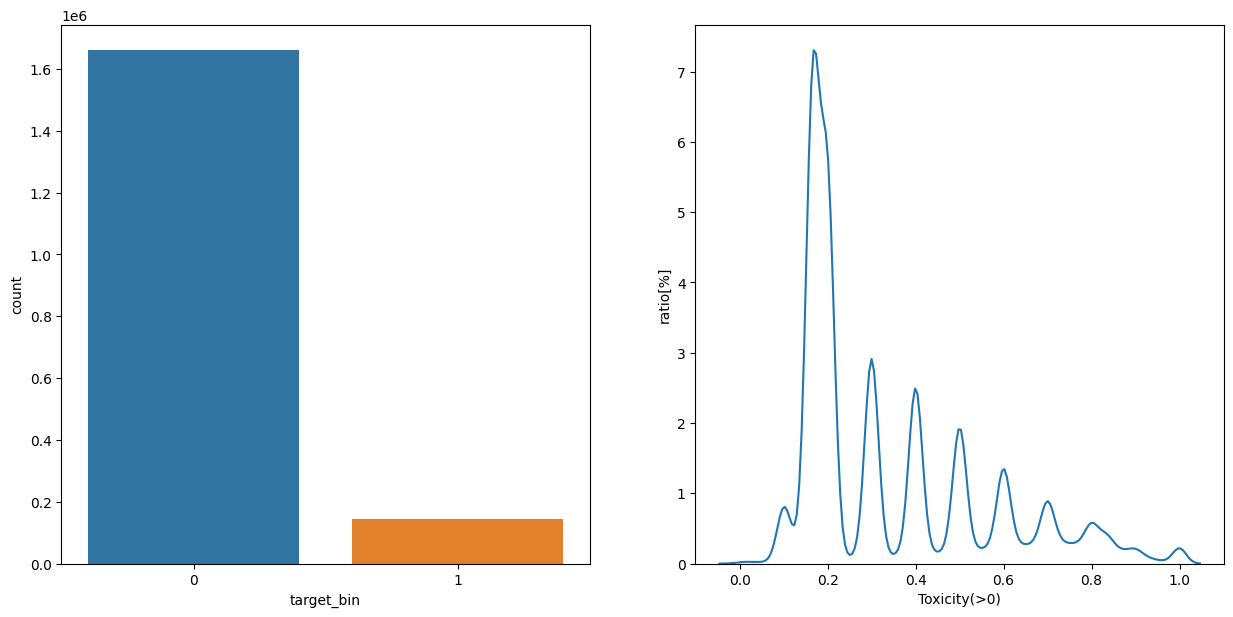

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
sns.countplot(x='target_bin', data=df_train, ax=ax1)
sns.kdeplot(x='target', data=df_train[df_train['target'] > 0], ax=ax2)
ax2.set_ylabel("ratio[%]")
ax2.set_xlabel("Toxicity(>0)")
plt.show()